### TODO:

###### Build up fundamental model:
-Test speeds vs traditional methods  
-Energy distance test for distributions  
-Check distributions of variables within households, compare to naive method w/borysov model somehow  
-Test making epsilon the same distribution as the actual posteriors in the model

###### Differentiate from the GenSynth paper:
-Travel diaries  
-Method/heuristic/rules for checking large number of attributes  
-New models; Disentangled VAE/GAN  
-Model population changes over time RNN  
-Behavioral variables  

###### They suggest:
-Incorporate RNN to generate trip chains (time, location, mode, purpose)  
-Use GAN/other method to generate less inconsistencies  
-Address next stage of re-sampling to get future populations  

In [38]:
# Each input to training the model is a person's daily trip diary
# Inputs; day of week, characteristics of person/hh
# Outputs; trip purpose, mode, duration, distance
# How to include Time of Day?
# Timesteps could either be hours in the day, or trips in a chain?
    # If a timestep is a trip, add the time of departure to the output variables
    
# Timestep is a trip
# Output of each timestep is departure time, duration, distance, mode, and purpose (y)
# Input of each timestep is person/hh variables, day of week, and previous timestep info (x)

## Import Libraries and Datasets

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.preprocessing as skpre
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [40]:
# Load in the persons PUMS dataset for WA state
t_df = pd.read_csv('data/NHTS/nhts_survey/trippub.csv')
p_df = pd.read_csv('data/NHTS/nhts_survey/perpub.csv')
h_df = pd.read_csv('data/NHTS/nhts_survey/hhpub.csv')

## Choose Variables and Preprocess

In [41]:
# Filter to desired variables (numeric then categorical)
#TRIPPURP = simplified why/from
nhts_data_t = t_df[['TDCASEID','HOUSEID','PERSONID','TDAYDATE','TRAVDAY','TDTRPNUM','STRTTIME','TRVLCMIN','TRPMILES','TRPTRANS','WHYFROM','WHYTO']]
nhts_data_p = p_df[['HOUSEID','PERSONID','R_AGE','TIMETOWK','EDUC','R_SEX','OCCAT']]
nhts_data_h = h_df[['HOUSEID','HHSIZE','HHFAMINC','HHVEHCNT']]
del t_df
del p_df
del h_df
nhts_data = pd.merge(nhts_data_t, nhts_data_h, on='HOUSEID', how='left')
nhts_data = pd.merge(nhts_data, nhts_data_p, on=['HOUSEID', 'PERSONID'], how='left')

# Give each set of daily trips a unique chain id (each will be an input to model)
nhts_data['CHAINID'] = nhts_data.groupby(['TDAYDATE','HOUSEID','PERSONID']).ngroup().values
nhts_data = nhts_data.drop(labels=['TDAYDATE','TDCASEID','HOUSEID','PERSONID'], axis=1)

# Remove NA values and check n before/after
print(f"Dataset n={len(nhts_data)} pre-cleaning")
nan_indices = list((nhts_data < 0).any(axis=1))
nan_ids = nhts_data[nan_indices][['CHAINID']].values.flatten()
nhts_data = nhts_data[~(nhts_data['CHAINID'].isin(nan_ids))]
print(f"Dataset n={len(nhts_data)} post-cleaning")

Dataset n=923572 pre-cleaning
Dataset n=405590 post-cleaning


In [42]:
# Only numeric variables, only dynamic variables
nhts_data = nhts_data[['TRAVDAY','TDTRPNUM','STRTTIME','TRVLCMIN','TRPMILES','TRPTRANS','CHAINID']].copy()
MANIFEST_DIM = nhts_data.values.shape[1]-1 # All except chainid

In [43]:
# Preview data that will be fed into model
model_data_df = nhts_data
model_data_df

,TRAVDAY,TDTRPNUM,STRTTIME,TRVLCMIN,TRPMILES,TRPTRANS,CHAINID
2,2,1,700,120,84.004,6,46938
3,2,2,1800,150,81.628,6,46938
6,5,1,1115,15,8.017,6,46940
7,5,2,2330,10,8.017,6,46940
8,5,1,550,15,3.395,4,24626
...,...,...,...,...,...,...,...
923567,3,1,810,27,1.168,1,93638
923568,3,2,1320,8,0.238,1,93638
923569,3,3,1415,5,0.238,1,93638
923570,3,4,1820,25,0.867,1,93638


In [44]:
# Remove chains that have more than 5 trips in them
MAX_TIMESTEPS = 5  # Make sure to add 1 when generating the chain data (1 gets removed in training)
long_chains = model_data_df[model_data_df['TDTRPNUM'] > MAX_TIMESTEPS+1][['CHAINID']].values.flatten()
model_data_df = model_data_df[~model_data_df['CHAINID'].isin(long_chains)]
print(len(pd.unique(long_chains)))

## Remove outliers
# Filter model data into train/test data
chain_ids = pd.unique(model_data_df['CHAINID'])
train_idx = round(len(chain_ids)*.9)
train_ids = chain_ids[0:train_idx]
test_ids = chain_ids[train_idx:len(chain_ids)]
train_data_df = model_data_df[model_data_df['CHAINID'].isin(train_ids)]
test_data_df = model_data_df[model_data_df['CHAINID'].isin(test_ids)]

# Standardize the input data from -1 to 1 for numerical variables, remove outliers (x > 3 SD)
scaler_train = skpre.StandardScaler()
scaler_test = skpre.StandardScaler()
train_data = scaler_train.fit_transform(train_data_df.values)
test_data = scaler_test.fit_transform(test_data_df.values)

# Remove outliers from dataset once for training data...
outlier_indices = np.where(np.any(train_data > 3, axis=1))[0]
outlier_chains = train_data_df.iloc[outlier_indices,:][['CHAINID']].values.flatten()
train_data_df = train_data_df[~train_data_df['CHAINID'].isin(outlier_chains)]
print(len(outlier_chains))

# ...and again for testing data (keep the scalers separate)
outlier_indices = np.where(np.any(test_data > 3, axis=1))[0]
outlier_chains = test_data_df.iloc[outlier_indices,:][['CHAINID']].values.flatten()
test_data_df = test_data_df[~test_data_df['CHAINID'].isin(outlier_chains)]
print(len(outlier_chains))

15040
4448
467


In [45]:
# Reshape the model data to a format that is usable by tensorflow: shape = (#samples, timestep size, #features)
train_samples_x = []
train_samples_y = []
chain_ids = pd.unique(train_data_df['CHAINID'])
train_data_df.iloc[:,:MANIFEST_DIM] = scaler_train.fit_transform(train_data_df.iloc[:,:MANIFEST_DIM].values)  # Scale all variables except Chainid

# This could be faster
for chain_id in chain_ids:
    data = train_data_df[train_data_df['CHAINID'] == chain_id].values.transpose()
    data = keras.preprocessing.sequence.pad_sequences(data, MAX_TIMESTEPS+1, padding='pre').transpose()
    data = data[:,:-1]  # Remove Chainid
    data_offset = data[1:,:]  # Validation data is offset by 1 timestep
    data = data[:-1,:]  # Remove the final timestep from input data (no validation for it)
    train_samples_x.append(data)
    train_samples_y.append(data_offset)

# Dimensions are: (samples, timesteps, features)
train_data_x = np.array(train_samples_x)
train_data_y = np.array(train_samples_y)

In [46]:
# Reshape the model data to a format that is usable by tensorflow: shape = (#samples, timestep size, #features)
# TODO: Make sure this is working correctly
test_samples_x = []
test_samples_y = []
chain_ids = pd.unique(test_data_df['CHAINID'])
test_data_df.iloc[:,:MANIFEST_DIM] = scaler_test.fit_transform(test_data_df.iloc[:,:MANIFEST_DIM].values)  # Scale all variables except Chainid

# This could be faster
for chain_id in chain_ids:
    data = test_data_df[test_data_df['CHAINID'] == chain_id].values.transpose()
    data = keras.preprocessing.sequence.pad_sequences(data, MAX_TIMESTEPS+1, padding='pre').transpose()
    data = data[:,:-1]  # Remove Chainid
    data_offset = data[1:,:]  # Validation data is offset by 1 timestep
    data = data[:-1,:]  # Remove the final timestep from input data (no validation for it)
    test_samples_x.append(data)
    test_samples_y.append(data_offset)

# Dimensions are: (samples, timesteps, features)
test_data_x = np.array(test_samples_x)
test_data_y = np.array(test_samples_y)

In [47]:
# shape = (#samples, timestep size, #features)
print(train_data_x.shape)
print(train_data_y.shape)
print(test_data_x.shape)
print(test_data_y.shape)

(69288, 5, 6)
(69288, 5, 6)
(7733, 5, 6)
(7733, 5, 6)


## Set Parameters and Define Model

In [48]:
# Timestep is a trip
# Output of each timestep is departure time, duration, distance, mode, and purpose (dynamic)
# Input of each timestep is person/hh variables, day of week, and previous timestep info (static + dynamic)

# Hyperparameters
BATCH_SIZE = 100
EPOCHS = 5
LEARN_RATE = 0.01
RHO = 0.9

In [49]:
# I should try embedding trips as a classification => one for each mode, orig/dest purpose
# How to do dist/time/other? Separate variables?

# LSTM layer requires inputs to be 3D tensor with shape [batch, timesteps, feature]
inputs = keras.Input(shape=(MAX_TIMESTEPS, MANIFEST_DIM))
dense = layers.Dense(10, activation="tanh")(inputs)
lstm = layers.LSTM(10, activation="tanh", return_sequences=True)(dense)
outputs = layers.Dense(MANIFEST_DIM, activation="tanh")(lstm)

# Define and print model
model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 5, 6)]            0         
_________________________________________________________________
dense_4 (Dense)              (None, 5, 10)             70        
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 10)             840       
_________________________________________________________________
dense_5 (Dense)              (None, 5, 6)              66        
Total params: 976
Trainable params: 976
Non-trainable params: 0
_________________________________________________________________


## Training

In [50]:
filepath="./model_checkpoints/weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [51]:
# Compile and train the model
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.RMSprop(learning_rate=LEARN_RATE, rho=RHO))
history = model.fit(train_data_x, train_data_y, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks_list)

Epoch 1/5
691/693 [============================>.] - ETA: 0s - loss: 0.2354
Epoch 00001: loss improved from inf to 0.23541, saving model to ./model_checkpoints/weights-improvement-01-0.2354.hdf5
693/693 [==============================] - 4s 5ms/step - loss: 0.2354
Epoch 2/5
691/693 [============================>.] - ETA: 0s - loss: 0.2256
Epoch 00002: loss improved from 0.23541 to 0.22558, saving model to ./model_checkpoints/weights-improvement-02-0.2256.hdf5
693/693 [==============================] - 4s 5ms/step - loss: 0.2256
Epoch 3/5
686/693 [============================>.] - ETA: 0s - loss: 0.2240
Epoch 00003: loss improved from 0.22558 to 0.22385, saving model to ./model_checkpoints/weights-improvement-03-0.2239.hdf5
693/693 [==============================] - 3s 4ms/step - loss: 0.2239
Epoch 4/5
682/693 [============================>.] - ETA: 0s - loss: 0.2228
Epoch 00004: loss improved from 0.22385 to 0.22264, saving model to ./model_checkpoints/weights-improvement-04-0.2226.hdf

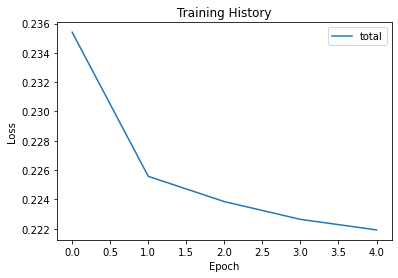

In [52]:
# Plot model loss/training progress
plt.plot(history.history['loss'])
plt.title("Training History")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["total"], loc="upper right")
plt.show()

## Testing

In [56]:
# Load the weights from the best result of the training
filename = "./model_checkpoints/weights-improvement-05-0.2219.hdf5"
model.load_weights(filename)
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.RMSprop(learning_rate=LEARN_RATE, rho=RHO))

In [57]:
# Generate 10 trip chains, each with MAXTIMESTEPS timesteps (each represents 1 day for 1 individual)
NUM_CHAINS = 10
result_chains = []

for i in range(NUM_CHAINS):
    seed = np.random.rand(MAX_TIMESTEPS, MANIFEST_DIM)
    #seed = np.zeros((MAX_TIMESTEPS, MANIFEST_DIM))  # Generate either random, or zero-based seed for first trip
    seed = np.reshape(seed, (1, MAX_TIMESTEPS, MANIFEST_DIM))

    # Make first prediction to start from
    prediction = model.predict(seed, verbose=0)
    result = prediction

    # After each prediction, add the prediction to the results and re-predict the remaining timesteps from the results
    for j in range(1, MAX_TIMESTEPS):
        prediction = model.predict(result, verbose=0)
        result[:,j:,:] = prediction[:,j:,:]
    result_chains.append(result)

In [58]:
# Get the data in the same dimensions as the input data
synthetic_chains = np.array(result_chains).reshape(NUM_CHAINS, MAX_TIMESTEPS, MANIFEST_DIM)

# Assign a trip chain id to each synthetic chain
chain_ids = []
# Get np array of chain ids to append, must be same dims as the synthetic results
for i in range(NUM_CHAINS):
    to_add = np.zeros(MAX_TIMESTEPS) + i
    to_add = np.reshape(to_add, (MAX_TIMESTEPS, 1))
    chain_ids.append(to_add)
chain_ids = np.array(chain_ids)
synthetic_chains = np.append(synthetic_chains, chain_ids, axis=2).reshape((NUM_CHAINS*MAX_TIMESTEPS), MANIFEST_DIM+1)

# Scale the results back to real values
synthetic_chains[:MANIFEST_DIM,:] = scaler_train.inverse_transform(synthetic_chains[:MANIFEST_DIM,:])

ValueError: operands could not be broadcast together with shapes (6,7) (6,) (6,7) 

In [62]:
MANIFEST_DIM

6

In [65]:
synthetic_chains[:,:]

array([[ 3.95438701e-01,  8.34055364e-01,  3.96876335e-02,
         5.74612198e-03, -3.21390890e-02,  4.36797470e-01,
         0.00000000e+00],
       [ 3.31206739e-01,  9.91451859e-01,  8.14472497e-01,
        -1.44440308e-01, -2.79775411e-01,  5.94668686e-01,
         0.00000000e+00],
       [ 3.56876969e-01,  9.97133851e-01, -1.37743261e-03,
        -2.82231301e-01, -4.07551140e-01,  7.80320585e-01,
         0.00000000e+00],
       [ 3.67349029e-01,  9.98305976e-01,  9.19289827e-01,
        -3.42471302e-01, -4.51612890e-01,  7.40068555e-01,
         0.00000000e+00],
       [ 3.90197396e-01,  9.98731375e-01,  9.63475823e-01,
        -3.66345555e-01, -3.85327488e-01,  5.34668863e-01,
         0.00000000e+00],
       [ 5.76205850e-01,  4.81209785e-01,  6.34437144e-01,
         2.16421828e-01,  2.90794134e-01,  4.43634808e-01,
         1.00000000e+00],
       [ 3.78661990e-01,  9.92868841e-01,  5.28948188e-01,
         1.65907502e-01,  5.03748238e-01,  7.35679507e-01,
         1.0000000

In [ ]:
# Create results dataframe
synthetic_trips_df = pd.DataFrame(synthetic_chains)
synthetic_trips_df

In [ ]:
# Predict fewer than 1,000 characters as output for a given seed.
# Remove all punctuation from the source text, and therefore from the models’ vocabulary.
# Try a one hot encoded for the input sequences.
# Train the model on padded sentences rather than random sequences of characters.
# Increase the number of training epochs to 100 or many hundreds.
# Add dropout to the visible input layer and consider tuning the dropout percentage.
# Tune the batch size, try a batch size of 1 as a (very slow) baseline and larger sizes from there.
# Add more memory units to the layers and/or more layers.
# Experiment with scale factors (temperature) when interpreting the prediction probabilities.
# Change the LSTM layers to be “stateful” to maintain state across batches.

In [ ]:
# model = Sequential()
# model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(256))
# model.add(Dropout(0.2))
# model.add(Dense(y.shape[1], activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam')